# Multi-Armed Bandit with Gymnasium Environment Registration and Observation Wrapper Example

In [1]:
# Importing necessary libraries
import numpy as np
import gymnasium as gym
from gymnasium import spaces
from gymnasium.envs.registration import register
from gymnasium import ObservationWrapper
import matplotlib.pyplot as plt

## Creating the Multi-Armed Bandit Environment

In [2]:
class MultiArmedBanditEnv(gym.Env):
    """ Bandit that allways provides a payout upon taking an action.

    Actual reward is drawn from a normal distribution (q*(a), 1)
    """
    
    def __init__(self, num_arms=5):
        super(MultiArmedBanditEnv, self).__init__()
        self.action_space = spaces.Discrete(num_arms)
        self.observation_space = spaces.Discrete(1)

        # define Bandit payouts/rewards
        self.prob_dist = np.full(num_arms, 1)
        self.reward_dist_mu = [np.random.normal(1, 1) for _ in range(num_arms)]  # q*(a)
        self.reward_dist_sigma = [1 for _ in range(num_arms)]

        # special case for bandit
        self.state = 0
        
    def step(self, action):
        assert self.action_space.contains(action), f"Invalid action {action}"
        
        reward = np.random.normal(self.reward_dist_mu[action], self.reward_dist_sigma[action])
        done = True  # Each step is terminal in a multi-armed bandit
        truncated = False
        info = {}

        return self.state, reward, done, truncated, info
    
    def reset(self, seed=None, options=None):
        # Seed the RNG if a seed is provided
        if seed is not None:
            np.random.seed(seed)
        
        self.state = 0
        return self.state, {}
    
    def render(self, mode="human"):
        pass

    @property
    def optimal_arm(self):
        return np.argmax(env.unwrapped.action_values) + 1
    
    @property
    def action_values(self):
        return self.reward_dist_mu

## Register the environment with gymnasium

In [3]:
register(
    id='MultiArmedBandit-v0',
    entry_point=MultiArmedBanditEnv,
    max_episode_steps=1,
)

## Simulating the Bandit Problem

In [4]:
def simulate(env, num_pulls, strategy='random'):
    env.reset()
    num_actions = env.action_space.n
    
    rewards = np.zeros(num_pulls)     # Rewards at each step (for plotting)
    counts = np.zeros([num_actions])  # Count of pulls per action
    q_values = np.zeros([num_actions])  # Estimated Q-values (cumulative rewards per action)
    q_values_history = np.zeros([num_pulls, num_actions])  # To track Q-values at each step
    
    # Start simulation loop
    for i in range(num_pulls):
        
        if strategy == 'random':
            action = env.action_space.sample()
        elif strategy == 'greedy':
            if i > 0:
                # Exploit: choose the action with the highest estimated Q-value
                q_estimates = q_values / np.maximum(1, counts)  # Avoid division by zero
                action = np.argmax(q_estimates)
            else:
                # Random initial pull
                action = env.action_space.sample()
        
        _, reward, _, _, _ = env.step(action)
        
        # Update counts and Q-values for the selected action
        counts[action] += 1
        q_values[action] += reward  # Update cumulative reward for this action
        rewards[i] = reward  # Log reward for this step
        
        # Track Q-values at each step (for plotting later)
        q_values_history[i] = q_values / np.maximum(1, counts)  # Average Q-values
    
    return rewards, q_values_history  # Return both rewards and Q-values history

In [5]:
# Check optimal arm probabilities
env = gym.make('MultiArmedBandit-v0', num_arms=5)
print(f"Optimal arm: {env.unwrapped.optimal_arm} with probabilities {env.unwrapped.action_values}")

# Simulate
num_pulls = 1000
rewards_random, q_values_random = simulate(env, num_pulls, strategy='random')
rewards_greedy, q_values_greedy = simulate(env, num_pulls, strategy='greedy')  

Optimal arm: 2 with probabilities [0.35393742806554296, 0.6176407396025445, 0.4457160216750671, -0.5732302182118609, 0.45225786648443633]


## Visualization

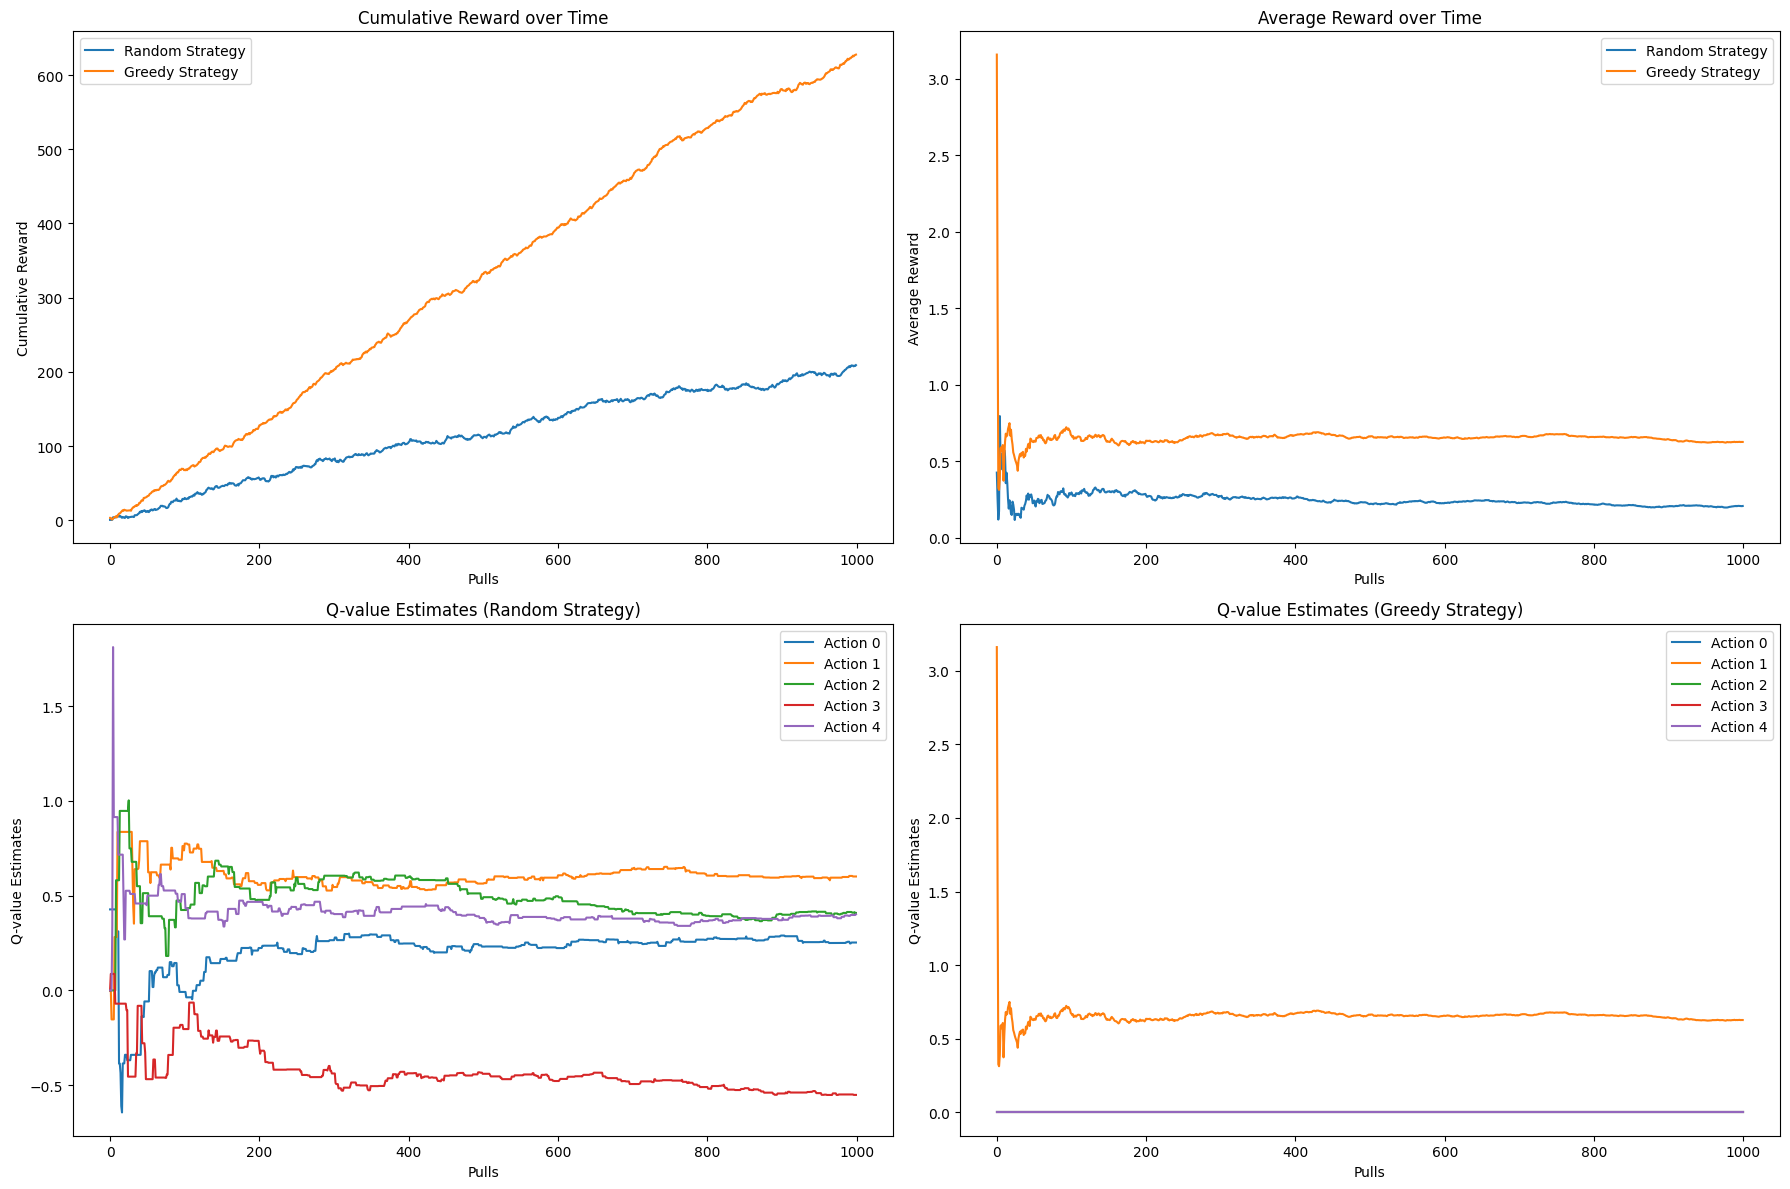

In [6]:
plt.figure(figsize=(18, 12))

# Plot cumulative rewards
plt.subplot(2, 2, 1)
plt.plot(np.cumsum(rewards_random), label='Random Strategy')
plt.plot(np.cumsum(rewards_greedy), label='Greedy Strategy')
plt.xlabel('Pulls')
plt.ylabel('Cumulative Reward')
plt.title('Cumulative Reward over Time')
plt.legend()

# Plot average reward
plt.subplot(2, 2, 2)
plt.plot(np.cumsum(rewards_random) / np.arange(1, num_pulls + 1), label='Random Strategy')
plt.plot(np.cumsum(rewards_greedy) / np.arange(1, num_pulls + 1), label='Greedy Strategy')
plt.xlabel('Pulls')
plt.ylabel('Average Reward')
plt.title('Average Reward over Time')
plt.legend()

# Plot Q-values (Random Strategy)
plt.subplot(2, 2, 3)
for action in range(env.action_space.n):
    plt.plot(q_values_random[:, action], label=f'Action {action}')
plt.xlabel('Pulls')
plt.ylabel('Q-value Estimates')
plt.title('Q-value Estimates (Random Strategy)')
plt.legend()

# Plot Q-values (Greedy Strategy)
plt.subplot(2, 2, 4)
for action in range(env.action_space.n):
    plt.plot(q_values_greedy[:, action], label=f'Action {action}')
plt.xlabel('Pulls')
plt.ylabel('Q-value Estimates')
plt.title('Q-value Estimates (Greedy Strategy)')
plt.legend()

plt.tight_layout()
plt.show()

## 4. Uncertainty-Estimating Wrapper

Problem: Bandit problems often involve balancing between exploring unknown arms and exploiting known good arms. Providing an explicit uncertainty measure can improve exploration strategies.

Solution: A wrapper could keep track of the variance or other measures of uncertainty associated with each action’s reward and return this information to the agent. This can be useful in algorithms like Upper Confidence Bound (UCB) or Thompson Sampling.

In [53]:
class UncertaintyWrapper(gym.Wrapper):
    def __init__(self, env):
        super(UncertaintyWrapper, self).__init__(env)
        self.action_counts = np.zeros(env.action_space.n)  # Count of times each action has been taken
        self.action_rewards = np.zeros(env.action_space.n)  # Sum of rewards for each action
        self.action_rewards_squared = np.zeros(env.action_space.n)  # Sum of squared rewards for variance calculation

    def step(self, action):
        # perform step with 
        obs, reward, done, truncated, info = self.env.step(action)
        
        # Update reward statistics
        self.action_counts[action] += 1
        self.action_rewards[action] += reward
        self.action_rewards_squared[action] += reward ** 2
        
        # Calculate the mean and variance of the reward for the action
        mean_reward = self.action_rewards[action] / self.action_counts[action]
        variance_reward = (self.action_rewards_squared[action] / self.action_counts[action]) - mean_reward ** 2

        # Add the mean and variance to the info dictionary for access
        info['mean_reward'] = mean_reward
        info['reward_variance'] = variance_reward
        
        return obs, reward, done, truncated, info

    def reset(self, **kwargs):
        
        base_env_reset = self.env.reset(**kwargs)
        
        # Reset statistics of wrapper
        self.action_counts = np.zeros(self.env.action_space.n)
        self.action_rewards = np.zeros(self.env.action_space.n)
        self.action_rewards_squared = np.zeros(self.env.action_space.n)
        
        return base_env_reset

In [64]:
def simulate_with_uncertainty(env, num_pulls, strategy='random'):
    rewards = np.zeros(num_pulls)  # Track rewards at each step
    action_counts = np.zeros(env.action_space.n)  # Count how many times each action is selected

    for i in range(num_pulls):
        if strategy == 'random':
            action = env.action_space.sample()
        elif strategy == 'greedy':
            # Exploit: choose action with the highest estimated mean reward
            action = np.argmax(env.action_rewards / np.maximum(1, action_counts))
        else:
            action = env.action_space.sample()  # Fallback to random

        # Step in the environment and retrieve the augmented observation and reward
        obs, reward, done, truncated, info = env.step(action)
        rewards[i] = reward
        action_counts[action] += 1
        
        # Display mean and variance of the selected action
        print(f"Step {i + 1} - Action {action}:    Reward {reward:.2f},     Mean Reward {info['mean_reward']:.2f},    Variance {info['reward_variance']:.2f}")

    return rewards

# Wrap the environment with the uncertainty wrapper
env = MultiArmedBanditEnv(num_arms=5)
wrapped_env = UncertaintyWrapper(env)

# Run the simulation
num_pulls = 10
rewards = simulate_with_uncertainty(wrapped_env, num_pulls, strategy='random')

Step 1 - Action 0:    Reward 1.64,     Mean Reward 1.64,    Variance 0.00
Step 2 - Action 4:    Reward 0.75,     Mean Reward 0.75,    Variance 0.00
Step 3 - Action 1:    Reward 1.32,     Mean Reward 1.32,    Variance 0.00
Step 4 - Action 2:    Reward 0.90,     Mean Reward 0.90,    Variance 0.00
Step 5 - Action 4:    Reward 0.25,     Mean Reward 0.50,    Variance 0.06
Step 6 - Action 4:    Reward 0.75,     Mean Reward 0.58,    Variance 0.06
Step 7 - Action 3:    Reward 2.27,     Mean Reward 2.27,    Variance 0.00
Step 8 - Action 1:    Reward 1.05,     Mean Reward 1.19,    Variance 0.02
Step 9 - Action 2:    Reward 0.83,     Mean Reward 0.86,    Variance 0.00
Step 10 - Action 1:    Reward 0.47,     Mean Reward 0.95,    Variance 0.12
